<a href="https://colab.research.google.com/github/dharm1k987/tensorflow_projects/blob/master/tensorflow_stock_prediction/Stock%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [45]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
!pip install pandas_datareader -q

# Import Stock Dataset

In [63]:
import pandas_datareader as pdr
from datetime import datetime

data = pdr.get_data_yahoo(symbols='AAPL', start=datetime(2006, 7, 18), end=datetime(2020, 7, 18))
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-07-18,7.692857,7.407143,7.594285,7.557143,250112100.0,6.542199
2006-07-19,7.868571,7.480000,7.565714,7.728571,347685800.0,6.690604
2006-07-20,8.798572,8.531428,8.708571,8.642858,493036600.0,7.482098
2006-07-21,8.735714,8.520000,8.545714,8.674286,222973100.0,7.509306
2006-07-24,8.871428,8.632857,8.751429,8.774285,180714100.0,7.595877


In [64]:
# this many entries
len(data['Close'])

3525

# Plot Data

In [48]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time since 2006-07-18")
    plt.ylabel("Closing Price")
    plt.grid(True)

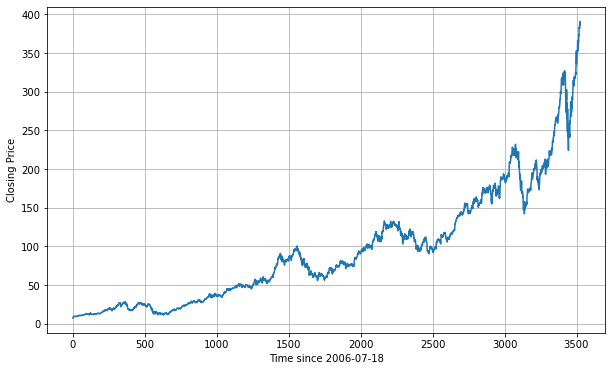

In [49]:
series = np.array(data['Close'])
time = range(len(data['Close']))
plt.figure(figsize=(10,6))
plot_series(time, series)

# Split Data

In [50]:
split_time = 3100
# use 3100 days for training and about 500 for testing
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size= 30
batch_size = 32
shuffle_buffer_size = 1000

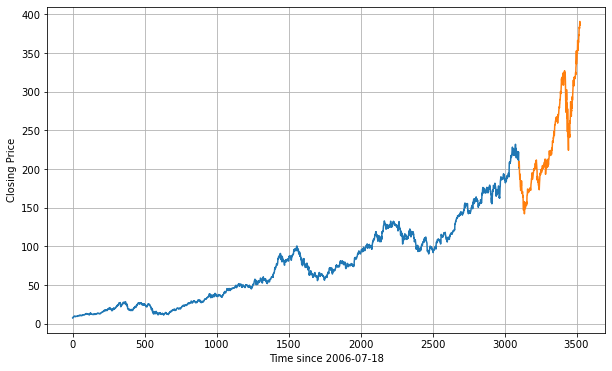

In [51]:
plt.figure(figsize=(10,6))
# blue is training, orange is testing
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

# Data Training Format

In [52]:
# create a windowed dataset which we will use to train the network later
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# First Model Attempt

In [53]:
window_size = 32
batch_size = 256
# get the training data
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3100,)


In [54]:
# create a model with LSTMs
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# find a good learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# compile and run the model
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 2s 160ms/step - loss: 115.0209 - mae: 115.5209 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 2s 155ms/step - loss: 112.0303 - mae: 112.5303 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 2s 153ms/step - loss: 106.9836 - mae: 107.4836 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 2s 148ms/step - loss: 92.3011 - mae: 92.8011 - lr: 1.4125e-0812 - mae
Epoch 5/100
12/12 [==============================] - 2s 153ms/step - loss: 82.6185 - mae: 83.1185 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 2s 153ms/step - loss: 73.9478 - mae: 74.4478 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 2s 153ms/step - loss: 64.3908 - mae: 64.8908 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 2s 149ms/step - loss: 53.7777 - mae: 54.2777 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 2s 148ms/step

Epoch 72/100
12/12 [==============================] - 2s 147ms/step - loss: 31.1007 - mae: 31.5968 - lr: 3.5481e-05
Epoch 73/100
12/12 [==============================] - 2s 151ms/step - loss: 37.4630 - mae: 37.9602 - lr: 3.9811e-05
Epoch 74/100
12/12 [==============================] - 2s 149ms/step - loss: 26.9040 - mae: 27.4006 - lr: 4.4668e-05
Epoch 75/100
12/12 [==============================] - 2s 147ms/step - loss: 21.5767 - mae: 22.0707 - lr: 5.0119e-05
Epoch 76/100
12/12 [==============================] - 2s 155ms/step - loss: 16.9083 - mae: 17.4010 - lr: 5.6234e-05
Epoch 77/100
12/12 [==============================] - 2s 150ms/step - loss: 23.8011 - mae: 24.2952 - lr: 6.3096e-05
Epoch 78/100
12/12 [==============================] - 2s 144ms/step - loss: 46.2203 - mae: 46.7186 - lr: 7.0795e-05
Epoch 79/100
12/12 [==============================] - 2s 151ms/step - loss: 71.0818 - mae: 71.5800 - lr: 7.9433e-05
Epoch 80/100
12/12 [==============================] - 2s 148ms/step - lo

(1e-08, 0.0001, 0.0, 60.0)

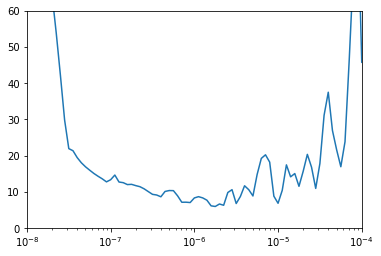

In [55]:
# plot a graph to pick out the best learning rate
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

# Second Model Attempt

In [56]:
train_set = windowed_dataset(x_train, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)

# same model but this time with a better learning rate
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# learning rate corresponds to lowest value in the graph above
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
31/31 [==============================] - 5s 173ms/step - loss: 37.0138 - mae: 37.5103
Epoch 2/500
31/31 [==============================] - 5s 168ms/step - loss: 39.0585 - mae: 39.5560
Epoch 3/500
31/31 [==============================] - 5s 167ms/step - loss: 37.6481 - mae: 38.1456 0s - loss: 37.7626 - mae: 3
Epoch 4/500
31/31 [==============================] - 5s 166ms/step - loss: 32.8458 - mae: 33.3429
Epoch 5/500
31/31 [==============================] - 5s 168ms/step - loss: 25.9181 - mae: 26.4139
Epoch 6/500
31/31 [==============================] - 5s 167ms/step - loss: 19.1702 - mae: 19.6617 2s - loss: 13.3873
Epoch 7/500
31/31 [==============================] - 5s 167ms/step - loss: 16.3981 - mae: 16.8860 2s - loss: 10.4514 - - ETA: 0s - loss: 15.5618 - mae: 16.
Epoch 8/500
31/31 [==============================] - 4s 129ms/step - loss: 14.9523 - mae: 15.4372
Epoch 9/500
31/31 [==============================] - 3s 106ms/step - loss: 14.2773 - mae: 14.7621
Epoch 10/500


Epoch 164/500
31/31 [==============================] - 5s 158ms/step - loss: 4.3187 - mae: 4.7604
Epoch 165/500
31/31 [==============================] - 5s 160ms/step - loss: 4.2981 - mae: 4.7384
Epoch 166/500
31/31 [==============================] - 5s 161ms/step - loss: 4.2135 - mae: 4.6510
Epoch 167/500
31/31 [==============================] - 5s 159ms/step - loss: 4.6148 - mae: 5.0614
Epoch 168/500
31/31 [==============================] - 5s 164ms/step - loss: 4.2253 - mae: 4.6629
Epoch 169/500
31/31 [==============================] - 5s 158ms/step - loss: 4.2037 - mae: 4.6425
Epoch 170/500
31/31 [==============================] - 5s 158ms/step - loss: 4.2629 - mae: 4.7041
Epoch 171/500
31/31 [==============================] - 5s 160ms/step - loss: 4.3439 - mae: 4.7870
Epoch 172/500
31/31 [==============================] - 5s 161ms/step - loss: 4.5840 - mae: 5.0314
Epoch 173/500
31/31 [==============================] - 5s 160ms/step - loss: 4.2470 - mae: 4.6873
Epoch 174/500
31/31 

31/31 [==============================] - 4s 121ms/step - loss: 3.3281 - mae: 3.7578
Epoch 323/500
31/31 [==============================] - 3s 106ms/step - loss: 3.3906 - mae: 3.8224
Epoch 324/500
31/31 [==============================] - 3s 110ms/step - loss: 3.3404 - mae: 3.7705
Epoch 325/500
31/31 [==============================] - 3s 107ms/step - loss: 3.3253 - mae: 3.7537
Epoch 326/500
31/31 [==============================] - 3s 107ms/step - loss: 3.3362 - mae: 3.7648
Epoch 327/500
31/31 [==============================] - 3s 108ms/step - loss: 3.3915 - mae: 3.8212
Epoch 328/500
31/31 [==============================] - 3s 108ms/step - loss: 3.3302 - mae: 3.7595
Epoch 329/500
31/31 [==============================] - 3s 105ms/step - loss: 3.4204 - mae: 3.8590
Epoch 330/500
31/31 [==============================] - 3s 108ms/step - loss: 3.5091 - mae: 3.9467
Epoch 331/500
31/31 [==============================] - 3s 105ms/step - loss: 3.4132 - mae: 3.8488
Epoch 332/500
31/31 [=============

Epoch 488/500
31/31 [==============================] - 3s 112ms/step - loss: 2.8009 - mae: 3.2287
Epoch 489/500
31/31 [==============================] - 4s 114ms/step - loss: 3.4591 - mae: 3.9114
Epoch 490/500
31/31 [==============================] - 3s 111ms/step - loss: 2.9956 - mae: 3.4342
Epoch 491/500
31/31 [==============================] - 4s 121ms/step - loss: 2.8573 - mae: 3.2870
Epoch 492/500
31/31 [==============================] - 4s 128ms/step - loss: 3.1898 - mae: 3.6329
Epoch 493/500
31/31 [==============================] - 4s 127ms/step - loss: 3.2133 - mae: 3.6678
Epoch 494/500
31/31 [==============================] - 4s 117ms/step - loss: 2.8593 - mae: 3.2960
Epoch 495/500
31/31 [==============================] - 4s 119ms/step - loss: 2.8227 - mae: 3.2575
Epoch 496/500
31/31 [==============================] - 4s 137ms/step - loss: 2.7537 - mae: 3.1795
Epoch 497/500
31/31 [==============================] - 4s 122ms/step - loss: 2.8940 - mae: 3.3268
Epoch 498/500
31/31 

# Showcase Results

In [57]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [58]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

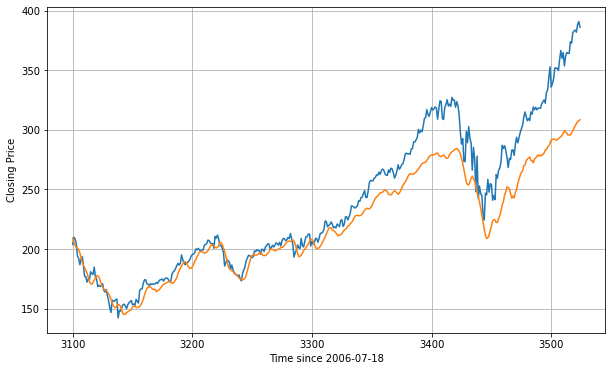

In [59]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [60]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

18.264217